In [33]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [34]:
data = pd.read_csv('bitcoinfinal.csv', header = None)
data.head()

,0,1
0,0,217.4
1,1,255.7
2,2,244.3
3,3,236.1
4,4,228.7


In [35]:
data.columns = ['Month','Price']
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data = data.set_index('Month')
data.head(12)

,Price
Month,
1970-01-01 00:00:00.000000000,217.4
1970-01-01 00:00:00.000000001,255.7
1970-01-01 00:00:00.000000002,244.3
1970-01-01 00:00:00.000000003,236.1
1970-01-01 00:00:00.000000004,228.7
1970-01-01 00:00:00.000000005,262.9
1970-01-01 00:00:00.000000006,284.5
1970-01-01 00:00:00.000000007,231.4
1970-01-01 00:00:00.000000008,236.5


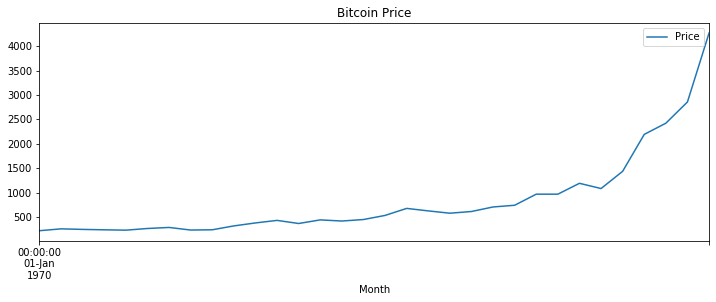

In [36]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Bitcoin Price')
plt.show(block=False)

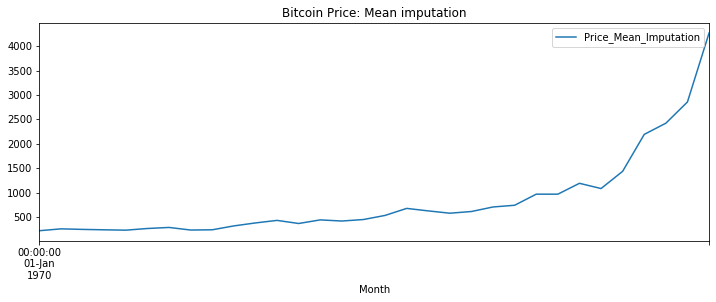

In [37]:
data = data.assign(Price_Mean_Imputation=data.Price.fillna(data.Price.mean()))
data[['Price_Mean_Imputation']].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Bitcoin Price: Mean imputation')
plt.show(block=False)

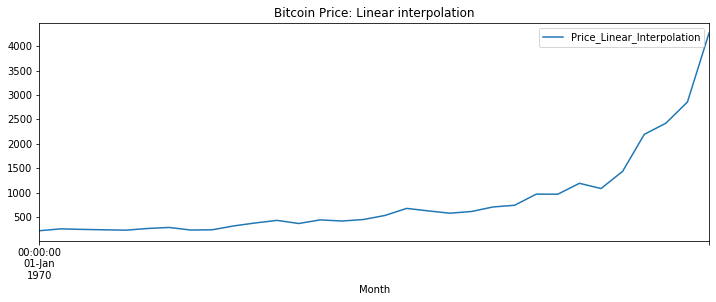

In [38]:
data = data.assign(Price_Linear_Interpolation=data.Price.interpolate(method='linear'))
data[['Price_Linear_Interpolation']].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Bitcoin Price: Linear interpolation')
plt.show(block=False)

In [39]:
data['Price'] = data['Price_Linear_Interpolation']
data.drop(columns=['Price_Mean_Imputation','Price_Linear_Interpolation'],inplace=True)

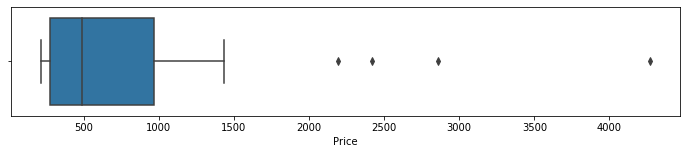

In [40]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=data['Price'],whis=1.5)

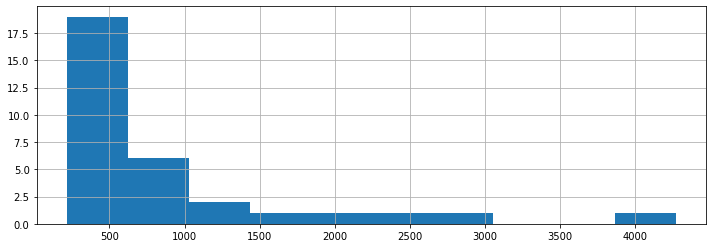

In [41]:
fig = data.Price.hist(figsize = (12,4))

In [42]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data.Price, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

ValueError: freq N not understood. Please report if you think this is in error.

In [43]:
decomposition = sm.tsa.seasonal_decompose(data.Price, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

ValueError: freq N not understood. Please report if you think this is in error.

In [44]:
train_len = 29
train = data[0:train_len] # first 29 months as training set
test = data[train_len:] # last 3 months as out-of-time test set

In [45]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Price'][train_len-1]

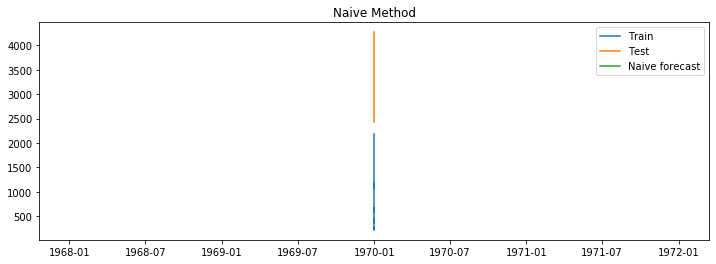

In [46]:
plt.figure(figsize=(12,4))
plt.plot(train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

In [51]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Price'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Price']-y_hat_naive['naive_forecast'])/test['Price'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,1265.9,27.12


In [52]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Price'].mean()

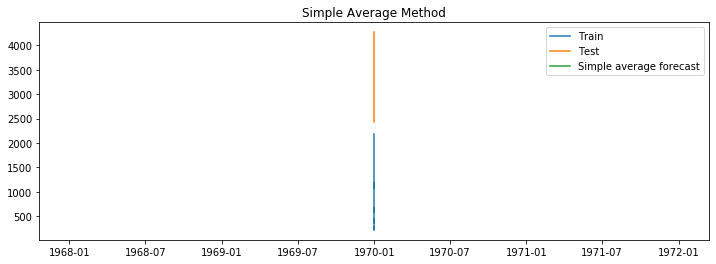

In [53]:
plt.figure(figsize=(12,4))
plt.plot(train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

In [55]:
rmse = np.sqrt(mean_squared_error(test['Price'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Price']-y_hat_avg['avg_forecast'])/test['Price'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,1265.90,27.12
0,Simple average method,2703.73,80.19


In [70]:
y_hat_sma = data.copy()
ma_window = 3
y_hat_sma['sma_forecast'] = data['Price'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

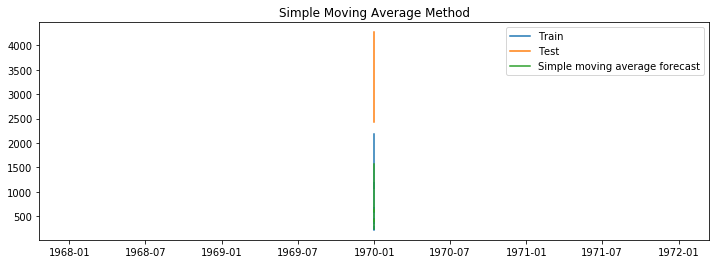

In [71]:
plt.figure(figsize=(12,4))
plt.plot(train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [72]:
rmse = np.sqrt(mean_squared_error(test['Price'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Price']-y_hat_sma['sma_forecast'][train_len:])/test['Price'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,1265.90,27.12
0,Simple average method,2703.73,80.19
0,Simple moving average forecast,2338.94,67.42
0,Simple moving average forecast,2338.94,67.42
0,Simple moving average forecast,2035.79,56.61
0,Simple moving average forecast,1794.92,47.81


In [79]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Price'])
model_fit = model.fit(smoothing_level=0.2,optimized=True)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(24)

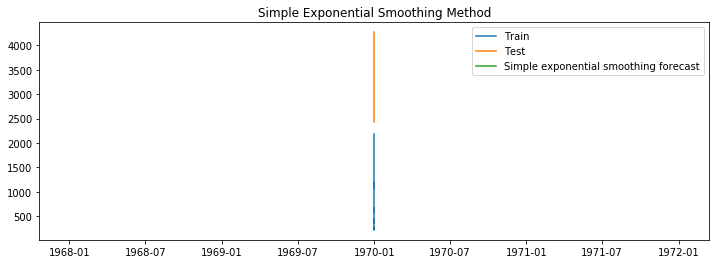

In [80]:
plt.figure(figsize=(12,4))
plt.plot(train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

In [81]:
rmse = np.sqrt(mean_squared_error(test['Price'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Price']-y_hat_ses['ses_forecast'])/test['Price'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Naive method,1265.90,27.12
0,Simple average method,2703.73,80.19
0,Simple moving average forecast,2338.94,67.42
0,Simple moving average forecast,2338.94,67.42
0,Simple moving average forecast,2035.79,56.61
0,Simple moving average forecast,1794.92,47.81
0,Simple exponential smoothing forecast,2107.13,59.17
0,Simple exponential smoothing forecast,2107.06,59.17


In [105]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['Price']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level=0.9, smoothing_slope=0.01, optimized=True)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.9, 'smoothing_slope': 0.01, 'smoothing_seasonal': nan, 'damping_slope': nan, 'initial_level': 146.15896831544845, 'initial_slope': 67.4190223715087, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


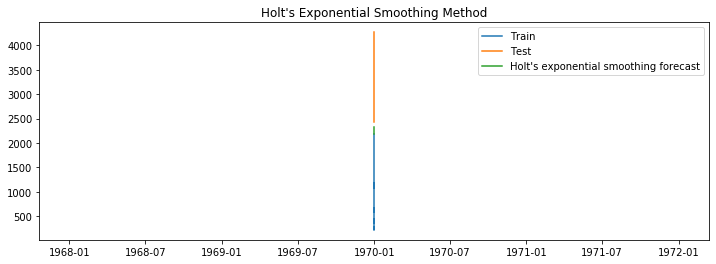

In [106]:
plt.figure(figsize=(12,4))
plt.plot( train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

In [107]:
rmse = np.sqrt(mean_squared_error(test['Price'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Price']-y_hat_holt['holt_forecast'])/test['Price'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,1265.90,27.12
0,Simple average method,2703.73,80.19
0,Simple moving average forecast,2338.94,67.42
0,Simple moving average forecast,2338.94,67.42
0,Simple moving average forecast,2035.79,56.61
0,Simple moving average forecast,1794.92,47.81
0,Simple exponential smoothing forecast,2107.13,59.17
0,Simple exponential smoothing forecast,2107.06,59.17
0,Holt's exponential smoothing method,1838.87,50.29
0,Holt Winters' additive method,509.49,10.26


In [98]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Price']) ,seasonal_periods=3 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.9999, 'smoothing_slope': 0.42105263157894735, 'smoothing_seasonal': 0.0001, 'damping_slope': nan, 'initial_level': 559.53, 'initial_slope': 1.1444444444444395, 'initial_seasons': array([-342.13, -303.83, -315.23]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


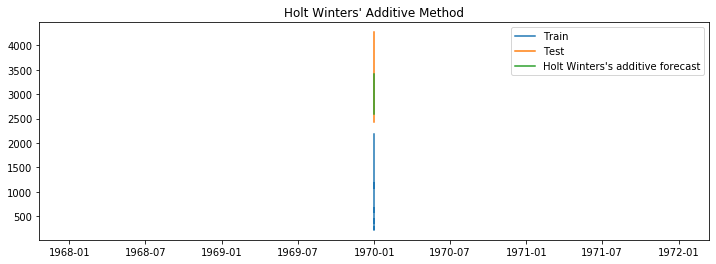

In [99]:
plt.figure(figsize=(12,4))
plt.plot( train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

In [100]:
rmse = np.sqrt(mean_squared_error(test['Price'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Price']-y_hat_hwa['hw_forecast'])/test['Price'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,1265.90,27.12
0,Simple average method,2703.73,80.19
0,Simple moving average forecast,2338.94,67.42
0,Simple moving average forecast,2338.94,67.42
0,Simple moving average forecast,2035.79,56.61
0,Simple moving average forecast,1794.92,47.81
0,Simple exponential smoothing forecast,2107.13,59.17
0,Simple exponential smoothing forecast,2107.06,59.17
0,Holt's exponential smoothing method,1838.87,50.29
0,Holt Winters' additive method,509.49,10.26


In [102]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Price']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 1.0, 'smoothing_slope': 0.8203632858208174, 'smoothing_seasonal': 0.0, 'damping_slope': nan, 'initial_level': 516.3662918828409, 'initial_slope': 26.208239816122965, 'initial_seasons': array([0.43532113, 0.48187911, 0.40439223, 0.47331682, 0.63578604,
       0.80773651, 0.70790656, 0.55164644, 0.48019517, 0.47495628,
       0.44181569, 0.4964509 ]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


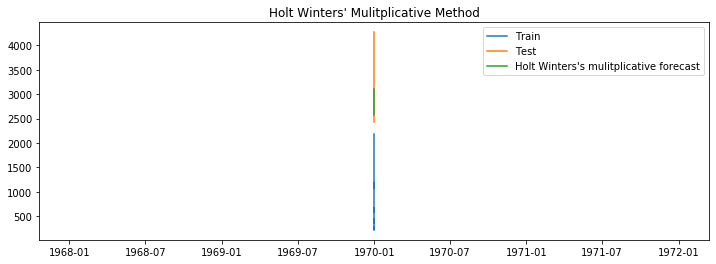

In [103]:
plt.figure(figsize=(12,4))
plt.plot( train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

In [104]:
rmse = np.sqrt(mean_squared_error(test['Price'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Price']-y_hat_hwm['hw_forecast'])/test['Price'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,1265.90,27.12
0,Simple average method,2703.73,80.19
0,Simple moving average forecast,2338.94,67.42
0,Simple moving average forecast,2338.94,67.42
0,Simple moving average forecast,2035.79,56.61
0,Simple moving average forecast,1794.92,47.81
0,Simple exponential smoothing forecast,2107.13,59.17
0,Simple exponential smoothing forecast,2107.06,59.17
0,Holt's exponential smoothing method,1838.87,50.29
0,Holt Winters' additive method,509.49,10.26
